# Fine-tune Llama 3.2 Vision Models with Unsloth on AMD MI300X

This tutorial demonstrates how to use **Unsloth** to fine-tune Llama 3.2 11B vision models on the ChartQA dataset using AMD Instinct GPUs. We create a synthetic dataset with chain-of-thought (CoT) reasoning to boost the inference accuracy of the model.

**Key Features:**
- 🚀 Unsloth for 2x faster training and 70% less memory
- 🎯 LoRA fine-tuning for efficient adaptation
- 📊 ChartQA dataset with synthetic reasoning
- 🔧 Optimized for AMD Instinct™ MI300X

**References:**

- [Unsloth GitHub](https://github.com/unslothai/unsloth)

## Prerequisites

### Hardware
- **AMD Instinct™ GPUs**: This tutorial was designed for AMD Instinct™ MI300X GPUs with ROCm support.

## 📚 Table of Contents

1. [Environment Setup](#environment-setup)
2. [Data Preparation](#data-preparation)
3. [Model Loading with Unsloth](#model-loading)
4. [Fine-Tuning with LoRA](#fine-tuning)
5. [Saving the Model](#saving-model)
6. [Load the Adapters](#lora-inference)

## 1. Environment Setup <a id="environment-setup"></a>

First, let's verify our environment and install required packages.

In [1]:
import os
import torch

# Verify GPU setup
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA/ROCm available: {torch.cuda.is_available()}")

PyTorch version: 2.8.0+gitb2fb688
CUDA/ROCm available: True


## 2. Data Preparation <a id="data-preparation"></a>

We'll use the ChartQA dataset with synthetic chain-of-thought reasoning. The CoT helps the model learn to reason step-by-step before giving the final answer.

In [2]:
from utils_unsloth import create_chart_qa_with_reasoning_dataset

create_chart_qa_with_reasoning_dataset(
    "reasoning.parquet",
    "cot_chartqa",
    override=True,
)

Loading reasoning data …
   columns : ['label']
   samples : 28299
Loading ChartQA from HuggingFace …
   ChartQA train samples: 28299


Creating parquet from Arrow format:   0%|          | 0/13 [00:00<?, ?ba/s]

Saved 28299 samples -> cot_chartqa

Sample #27901:
   query : How many monthly sessions per user did Netflix have?
   label : To find the number of monthly sessions per user for Netflix, I will look at the image and find the bar corresponding to Netflix. According to the image, the bar for Netflix is at 19. Therefore, the nu…


In [3]:
from datasets import load_dataset

# Load the datasets
print("Loading datasets...")

# Load original ChartQA for comparison
original_chartqa = load_dataset("HuggingFaceM4/ChartQA")

# Load our CoT dataset (saved as parquet)
reasoning_dataset = load_dataset("cot_chartqa")

print(f"\nDataset Statistics:")
print(f"   Training samples: {len(reasoning_dataset['train'])}")

Loading datasets...


Generating train split: 0 examples [00:00, ? examples/s]


Dataset Statistics:
   Training samples: 28299


In [4]:
# Compare original vs reasoning versions
sample_idx = 27901

print(f"📝 Sample Comparison (Index {sample_idx}):")
print(f"\n🔹 Query: {original_chartqa['train'][sample_idx]['query']}")
print(f"\n🔹 Original Answer: {original_chartqa['train'][sample_idx]['label']}")
print(f"\n🔹 Reasoning Version:\n{reasoning_dataset['train'][sample_idx]['label']}")

📝 Sample Comparison (Index 27901):

🔹 Query: How many monthly sessions per user did Netflix have?

🔹 Original Answer: ['19']

🔹 Reasoning Version:
To find the number of monthly sessions per user for Netflix, I will look at the image and find the bar corresponding to Netflix. According to the image, the bar for Netflix is at 19. Therefore, the number of monthly sessions per user for Netflix is 19.

Final answer: 19


📊 Sample Chart:


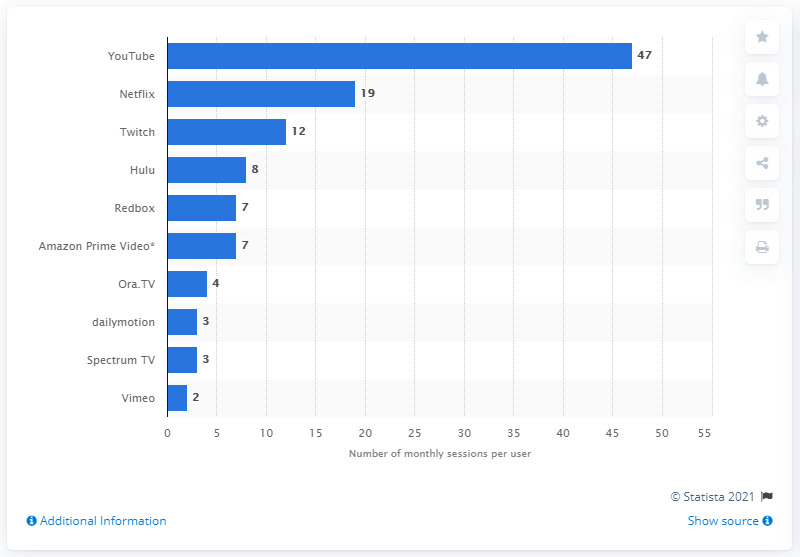

✅ Saved as example_chart.png


In [5]:
from IPython.display import display

# Display the sample image
sample = original_chartqa['train'][sample_idx]
if 'image' in sample:
    print("📊 Sample Chart:")
    display(sample['image'])
    
    # Save for later use
    sample['image'].save('example_chart.png')
    print("✅ Saved as example_chart.png")

### Format Dataset for Training

We need to convert the dataset to the conversation format expected by Unsloth/TRL.

In [6]:
from utils_unsloth import format_chartqa_for_vision_training

MAX_SAMPLES = 1000  # Adjust based on your needs

train_dataset = format_chartqa_for_vision_training(
    original_chartqa["train"],
    reasoning_dataset["train"],
    max_samples=MAX_SAMPLES,
)

print(f"\nSample formatted conversation:")
sample = train_dataset[0]
print(f"Messages structure:")
for msg in sample["messages"]:
    print(f"  {msg['role']}: {[c['type'] for c in msg['content']]}")

Formatting 1000 samples for vision training...


Formatting:   0%|          | 0/1000 [00:00<?, ?samples/s]

✓ Formatted 1000 vision samples (0 skipped — missing images)

Sample formatted conversation:
Messages structure:
  user: ['image', 'text']
  assistant: ['text']


Note: We formatted only 1000 examples from the whole data as an example.

## 3. Model Loading with Unsloth <a id="model-loading"></a>

Load the Llama 3.2 model using Unsloth's optimized loader. For vision tasks, we'll use the instruct model and train it on chart understanding.

In [7]:
import torch
import sys
import types

# Insert a dummy module BEFORE torchvision is imported
if "torchvision._meta_registrations" not in sys.modules:
    sys.modules["torchvision._meta_registrations"] = types.ModuleType("torchvision._meta_registrations")
    print("Applied torchvision _meta_registrations workaround for ROCm")

import torchvision
print(f"torchvision {torchvision.__version__} imported successfully")

from unsloth import FastVisionModel
from unsloth.chat_templates import train_on_responses_only

Applied torchvision _meta_registrations workaround for ROCm


/usr/local/lib/python3.12/dist-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


torchvision 0.23.0+cu128 imported successfully
🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
#### Unsloth: `hf_xet==1.1.10` and `ipykernel>6.30.1` breaks progress bars. Disabling for now in XET.
#### Unsloth: To re-enable progress bars, please downgrade to `ipykernel==6.30.1` or wait for a fix to
https://github.com/huggingface/xet-core/issues/526
INFO 02-11 21:12:33 [__init__.py:225] Automatically detected platform rocm.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [8]:
# Model configuration
max_seq_length = 2048  # Longer for detailed reasoning
dtype = torch.bfloat16 

# Load the model
# Note: For vision tasks, we use the instruct model. 
# Unsloth's vision support is evolving - check latest docs for vision-specific models
model_name = "unsloth/Llama-3.2-11B-Vision-Instruct"

print(f"🔄 Loading {model_name}...")

model, processor = FastVisionModel.from_pretrained(
    model_name=model_name,
    max_seq_length=max_seq_length,
    dtype=dtype,
)

print(f"✅ Model loaded successfully!")
print(f"   Model type: {type(model).__name__}")
print(f"   Dtype: {dtype}")

🔄 Loading unsloth/Llama-3.2-11B-Vision-Instruct...
Unsloth: AMD currently is not stable with 4bit bitsandbytes. Disabling for now.
==((====))==  Unsloth 2025.10.6: Fast Mllama patching. Transformers: 4.56.2. vLLM: 0.11.1rc2.dev161+g8a297115e.rocm700.
   \\   /|    . Num GPUs = 1. Max memory: 191.688 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+gitb2fb688. ROCm Toolkit: 7.0.51831-a3e329ad8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

✅ Model loaded successfully!
   Model type: MllamaForConditionalGeneration
   Dtype: torch.bfloat16


In [9]:
# Add LoRA adapters for efficient fine-tuning
print("🔧 Adding LoRA adapters...")

model = FastVisionModel.get_peft_model(
    model,
    r=16,  # LoRA rank
    finetune_vision_layers=True,     # Train vision encoder
    finetune_language_layers=True,   # Train language model
    finetune_attention_modules=True, # Train attention
    finetune_mlp_modules=True,       # Train MLP
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=42,
)

print("✅ LoRA adapters added!")

# Print trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"   Trainable parameters: {trainable_params:,} ({100*trainable_params/total_params:.2f}%)")
print(f"   Total parameters: {total_params:,}")

🔧 Adding LoRA adapters...
Unsloth: Making `model.base_model.model.model.vision_model.transformer` require gradients
✅ LoRA adapters added!
   Trainable parameters: 67,174,400 (0.63%)
   Total parameters: 10,737,395,235


## 4. Fine-Tuning with LoRA <a id="fine-tuning"></a>

Now we'll set up the training configuration and run fine-tuning.

In [10]:
from trl import SFTConfig, SFTTrainer
from unsloth.trainer import UnslothVisionDataCollator

print("🔧 Setting up trainer...")

# Training configuration optimized for AMD MI300X/MI325X
training_args = SFTConfig(
    # Batch settings - Vision models use more memory per sample
    per_device_train_batch_size=2,   # Smaller batch due to image memory
    gradient_accumulation_steps=8,    # Effective batch = 2 * 8 = 16
    
    # Training duration
    num_train_epochs=1,
    max_steps=10,
    
    # Learning rate (lower for vision models)
    learning_rate=2e-5,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    
    # Optimization
    optim="adamw_8bit",
    weight_decay=0.01,
    
    # Precision
    bf16=True,
    
    # Logging
    logging_steps=1,
    logging_dir="./logs",
    
    # Checkpointing
    output_dir="./checkpoints/chartqa_vision_unsloth",
    save_strategy="epoch",
    save_total_limit=2,
    
    # Memory optimization
    gradient_checkpointing=True,
    dataloader_pin_memory=False,
    dataloader_num_workers=0,
    
    # IMPORTANT for multimodal training:
    remove_unused_columns=False,
    dataset_kwargs={"skip_prepare_dataset": True},
    
    # Sequence length
    max_seq_length=max_seq_length,
    dataset_num_proc=1,
    
    # Misc
    seed=42,
    report_to="none",
)

# Create trainer with vision-compatible setup
# UnslothVisionDataCollator handles image + text batching for vision models
trainer = SFTTrainer(
    model=model,
    tokenizer=processor,
    data_collator=UnslothVisionDataCollator(model, processor),
    train_dataset=train_dataset,
    args=training_args,
)

print("✅ Trainer configured!")
print(f"   Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"   Learning rate: {training_args.learning_rate}")

🔧 Setting up trainer...
✅ Trainer configured!
   Effective batch size: 16
   Learning rate: 2e-05


In [11]:
# Start training
print("🚀 Starting training...")
print("="*50)

# Prepare model for training
FastVisionModel.for_training(model)

# Train!
trainer_stats = trainer.train()

print("="*50)
print("✅ Training complete!")
print(f"   Total steps: {trainer_stats.global_step}")
print(f"   Final loss: {trainer_stats.training_loss:.4f}")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009, 'bos_token_id': 128000}.


🚀 Starting training...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,000 | Num Epochs = 1 | Total steps = 10
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 8 x 1) = 16
 "-____-"     Trainable parameters = 67,174,400 of 10,737,395,235 (0.63% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.300200
2,1.372600
3,1.785200
4,1.298400
5,1.131300
6,1.194000
7,1.213900
8,1.115200
9,1.101100
10,1.308100


✅ Training complete!
   Total steps: 10
   Final loss: 1.2820


The above cell (max_steps=10) will show the tiny fine-tuning which will finish very soon.

<img src="./assets/Screenshot 2026-02-12 020007.png" alt="20step-11b" width="700" height="450">

Note that full fine-tuning (10 epochs) will take about 22 hours to finish. During this time and if the WandBLogger was enabled we can follow the progress online.

<img src="./assets/Screenshot 2026-02-12 022233.png" alt="epoch10-11b" width="700" height="450">

## 5. Saving the Model <a id="saving-model"></a>

Save the fine-tuned model for later use.

In [12]:
# Save LoRA adapters (lightweight)
lora_path = "./models/chartqa_lora"
print(f"💾 Saving LoRA adapters to {lora_path}...")

model.save_pretrained(lora_path)
processor.save_pretrained(lora_path)

print(f"✅ LoRA adapters saved!")

💾 Saving LoRA adapters to ./models/chartqa_lora...
✅ LoRA adapters saved!


## 6. Loading LoRA Adapters & Inference Comparison <a id="lora-inference"></a>

Now let's demonstrate the full workflow of **loading saved LoRA adapters** from disk, merging them with the base model, and comparing inference outputs against the unmodified base model.

This is the key step for deployment: you train once, save the lightweight LoRA adapters (~50MB vs ~22GB full model), and later load + merge them for inference.

In [13]:
# First, free memory from the training model if it's still loaded
import gc

try:
    del model, trainer
except NameError:
    pass

gc.collect()
torch.cuda.empty_cache()
print(f"GPU memory freed. Available: {torch.cuda.mem_get_info()[0] / 1e9:.1f} GB")

GPU memory freed. Available: 76.2 GB


### 6.1 Load the Base Model (No Fine-Tuning)

We load the original Llama 3.2 11B Vision Instruct model **without** any LoRA adapters to establish a baseline for comparison.

In [22]:
# Load the BASE model (no LoRA) for comparison
from unsloth import FastVisionModel

model_name = "unsloth/Llama-3.2-11B-Vision-Instruct"

print(f"Loading BASE model: {model_name} ...")
base_model, base_tokenizer = FastVisionModel.from_pretrained(
    model_name=model_name,
    max_seq_length=2048,
    dtype=torch.bfloat16,
    load_in_4bit=False,
)

FastVisionModel.for_inference(base_model)
base_processor = base_tokenizer

print(f"Base model loaded successfully!")
print(f"   Parameters: {sum(p.numel() for p in base_model.parameters()):,}")

Loading BASE model: unsloth/Llama-3.2-11B-Vision-Instruct ...
Unsloth: AMD currently is not stable with 4bit bitsandbytes. Disabling for now.
==((====))==  Unsloth 2025.10.6: Fast Mllama patching. Transformers: 4.56.2. vLLM: 0.11.1rc2.dev161+g8a297115e.rocm700.
   \\   /|    . Num GPUs = 1. Max memory: 191.688 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+gitb2fb688. ROCm Toolkit: 7.0.51831-a3e329ad8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Base model loaded successfully!
   Parameters: 10,670,220,835


### 6.2 Run Base Model Inference

Let's run the base model on a set of chart questions to see how it performs **before** fine-tuning.

In [23]:
import re
from PIL import Image
from datasets import load_dataset
from IPython.display import display, HTML

def run_inference(model, processor, question, image, max_new_tokens=512):
    """Run inference on a single question + image pair."""
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": f"Look at this chart and answer the following question.\n\nQuestion: {question}"}
            ]
        }
    ]
    
    input_text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    
    inputs = processor(
        images=[image],
        text=input_text,
        return_tensors="pt",
    ).to(model.device)
    
    input_len = inputs["input_ids"].shape[1]
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            use_cache=True,
        )
    
    response = processor.decode(outputs[0][input_len:], skip_special_tokens=True)
    return response.strip()

# Prepare test samples from the ChartQA dataset
original_chartqa = load_dataset("HuggingFaceM4/ChartQA")

test_indices = [0, 100, 500, 27901]
test_samples = []

for idx in test_indices:
    sample = original_chartqa["train"][idx]
    if sample.get("image") is not None:
        test_samples.append({
            "idx": idx,
            "question": sample["query"],
            "ground_truth": sample["label"],
            "image": sample["image"].convert("RGB"),
        })

print(f"Prepared {len(test_samples)} test samples")
for s in test_samples:
    print(f"  Sample #{s['idx']}: {s['question'][:80]}...")

Prepared 4 test samples
  Sample #0: Is the value of Favorable 38 in 2015?...
  Sample #100: What is China's economic strength in 2016?...
  Sample #500: What option is the smallest slice of this graph?...
  Sample #27901: How many monthly sessions per user did Netflix have?...


In [24]:
# Run inference with the BASE model
print("Running BASE model inference...")
print("=" * 60)

base_results = []
for s in test_samples:
    answer = run_inference(base_model, base_processor, s["question"], s["image"])
    base_results.append(answer)
    print(f"\nSample #{s['idx']}")
    print(f"  Q: {s['question']}")
    print(f"  Ground Truth: {s['ground_truth']}")
    print(f"  Base Model:   {answer}")

print("\n" + "=" * 60)
print(f"Base model inference complete ({len(base_results)} samples)")

Running BASE model inference...

Sample #0
  Q: Is the value of Favorable 38 in 2015?
  Ground Truth: ['Yes']
  Base Model:   Yes, the value of Favorable in 2015 is 38.

Sample #100
  Q: What is China's economic strength in 2016?
  Ground Truth: ['50']
  Base Model:   China's economic strength in 2016 was 52.

Sample #500
  Q: What option is the smallest slice of this graph?
  Ground Truth: ['Use Latinx']
  Base Model:   The smallest slice of the graph is 'Use Latinx', which represents 3% of the total.

Sample #27901
  Q: How many monthly sessions per user did Netflix have?
  Ground Truth: ['19']
  Base Model:   According to the chart, Netflix had 19 monthly sessions per user.

Base model inference complete (4 samples)


### 6.3 Load LoRA Adapters & Merge with Base Model

Now we load the saved LoRA adapters from disk and merge them into the base model. This is the standard deployment workflow:

1. **Load base model** (same as before)
2. **Load LoRA adapters** from the saved checkpoint
3. **Merge** adapters into the base model weights
4. **Run inference** with the enhanced model

In [25]:
# Free the base model to make room for the fine-tuned model
del base_model
gc.collect()
torch.cuda.empty_cache()

# ── Configuration ────────────────────────────────────────────────
HF_REPO_ID = "viani-sus/llama-3.2-11b-vision-chartqa-lora-unsloth"  # <-- Same repo ID as above
# ─────────────────────────────────────────────────────────────────

# Load the base model + LoRA adapters directly from the Hub
# FastVisionModel handles downloading the adapter config, detecting the
# base model from adapter_config.json, and applying the LoRA weights.
print(f"Pulling LoRA adapters from Hub: {HF_REPO_ID}")
finetuned_model, finetuned_processor = FastVisionModel.from_pretrained(
    model_name=HF_REPO_ID,   # HF repo ID instead of local path
    max_seq_length=2048,
    dtype=torch.bfloat16,
    load_in_4bit=False,
)

FastVisionModel.for_inference(finetuned_model)

# Show adapter info
trainable = sum(p.numel() for p in finetuned_model.parameters() if p.requires_grad)
total = sum(p.numel() for p in finetuned_model.parameters())
print(f"Fine-tuned model loaded!")
print(f"   LoRA adapter path: {lora_path}")
print(f"   Total parameters: {total:,}")
print(f"   LoRA parameters: {trainable:,} ({100*trainable/total:.2f}%)")

# Show the adapter file sizes
import os
adapter_files = [f for f in os.listdir(lora_path) if f.endswith(('.safetensors', '.bin', '.json'))]
total_size = sum(os.path.getsize(os.path.join(lora_path, f)) for f in adapter_files)
print(f"   Adapter files: {len(adapter_files)} files, {total_size / 1e6:.1f} MB total")
for f in sorted(adapter_files):
    size = os.path.getsize(os.path.join(lora_path, f))
    print(f"      {f}: {size / 1e6:.1f} MB")

Pulling LoRA adapters from Hub: viani-sus/llama-3.2-11b-vision-chartqa-lora-unsloth
Unsloth: AMD currently is not stable with 4bit bitsandbytes. Disabling for now.
==((====))==  Unsloth 2025.10.6: Fast Mllama patching. Transformers: 4.56.2. vLLM: 0.11.1rc2.dev161+g8a297115e.rocm700.
   \\   /|    . Num GPUs = 1. Max memory: 191.688 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+gitb2fb688. ROCm Toolkit: 7.0.51831-a3e329ad8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Fine-tuned model loaded!
   LoRA adapter path: ./models/chartqa_lora
   Total parameters: 10,737,395,235
   LoRA parameters: 67,174,400 (0.63%)
   Adapter files: 6 files, 286.1 MB total
      adapter_config.json: 0.0 MB
      adapter_model.safetensors: 268.9 MB
      preprocessor_config.json: 0.0 MB
      special_tokens_map.json: 0.0 MB
      tokenizer.json: 17.2 MB
      tokenizer_config.json: 0.1 MB


### 6.4 Run Fine-Tuned Model Inference

Now let's run the same questions through the fine-tuned model and compare the outputs.

In [26]:
# Run inference with the FINE-TUNED model (LoRA merged)
print("Running FINE-TUNED model inference...")
print("=" * 60)

finetuned_results = []       # Full CoT responses

for s in test_samples:
    full_response = run_inference(finetuned_model, finetuned_processor, s["question"], s["image"])
    finetuned_results.append(full_response)
    
    print(f"\nSample #{s['idx']}")
    print(f"  Q: {s['question']}")
    print(f"  Ground Truth:      {s['ground_truth']}")
    print(f"  Full CoT Response: {full_response}")

print("\n" + "=" * 60)
print(f"Fine-tuned model inference complete ({len(finetuned_results)} samples)")

Running FINE-TUNED model inference...

Sample #0
  Q: Is the value of Favorable 38 in 2015?
  Ground Truth:      ['Yes']
  Full CoT Response: There are two graphs in the diagram. A green showing the Favorable trend, and an orange showing the Unfavorable trend. In 2015 the value of the green graph is 38. Final answer: Yes

Sample #100
  Q: What is China's economic strength in 2016?
  Ground Truth:      ['50']
  Full CoT Response: To determine China's economic strength in 2016, we need to analyze the graph. The graph shows two lines representing China's economic strength and military strength over time. In 2016, the line for China's economic strength is at 50%. Therefore, China's economic strength in 2016 is 50%.

Final answer: 50

Sample #500
  Q: What option is the smallest slice of this graph?
  Ground Truth:      ['Use Latinx']
  Full CoT Response: The graph shows the percentage of Latino adults who have heard of the term Latinx and those who have not. The smallest slice of this grap

### 6.5 Side-by-Side Comparison

Let's visualize the results side by side to clearly see the improvement from fine-tuning. The fine-tuned model should provide **chain-of-thought reasoning** before giving the final answer, while the base model typically gives short, often incorrect answers.

COMPARISON: Base Model vs Fine-Tuned Model (LoRA)

────────────────────────────────────────────────────────────────────────────────
SAMPLE #0
────────────────────────────────────────────────────────────────────────────────


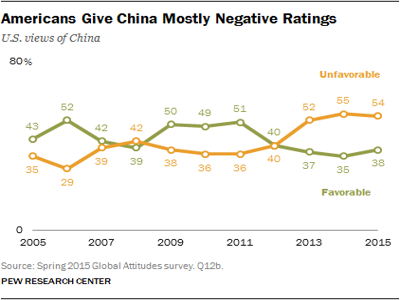


Question:     Is the value of Favorable 38 in 2015?
Ground Truth: ['Yes']

--- Base Model (before fine-tuning) ---
Yes, the value of Favorable in 2015 is 38.

--- Fine-Tuned Model (with LoRA) ---
Full CoT: There are two graphs in the diagram. A green showing the Favorable trend, and an orange showing the Unfavorable trend. In 2015 the value of the green graph is 38. Final answer: Yes

────────────────────────────────────────────────────────────────────────────────
SAMPLE #100
────────────────────────────────────────────────────────────────────────────────


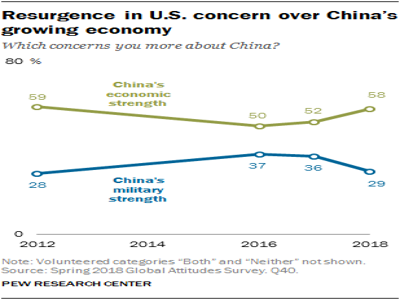


Question:     What is China's economic strength in 2016?
Ground Truth: ['50']

--- Base Model (before fine-tuning) ---
China's economic strength in 2016 was 52.

--- Fine-Tuned Model (with LoRA) ---
Full CoT: To determine China's economic strength in 2016, we need to analyze the graph. The graph shows two lines representing China's economic strength and military strength over time. In 2016, the line for China's economic strength is at 50%. Therefore, China's economic strength in 2016 is 50%.

Final answer: 50

────────────────────────────────────────────────────────────────────────────────
SAMPLE #500
────────────────────────────────────────────────────────────────────────────────


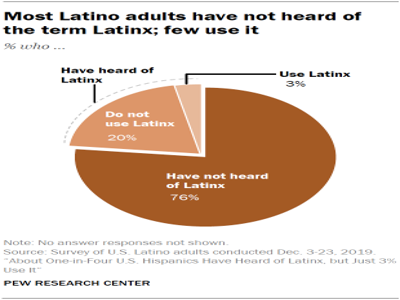


Question:     What option is the smallest slice of this graph?
Ground Truth: ['Use Latinx']

--- Base Model (before fine-tuning) ---
The smallest slice of the graph is 'Use Latinx', which represents 3% of the total.

--- Fine-Tuned Model (with LoRA) ---
Full CoT: The graph shows the percentage of Latino adults who have heard of the term Latinx and those who have not. The smallest slice of this graph is "Use Latinx" with 3%. Final answer: Use Latinx

────────────────────────────────────────────────────────────────────────────────
SAMPLE #27901
────────────────────────────────────────────────────────────────────────────────


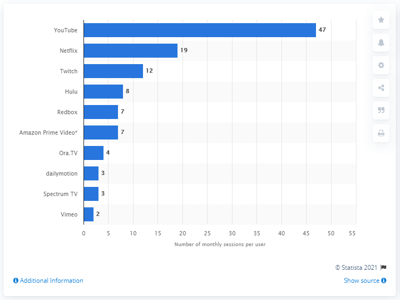


Question:     How many monthly sessions per user did Netflix have?
Ground Truth: ['19']

--- Base Model (before fine-tuning) ---
According to the chart, Netflix had 19 monthly sessions per user.

--- Fine-Tuned Model (with LoRA) ---
Full CoT: According to the chart, Netflix had 19 monthly sessions per user.Final answer: 19


In [27]:
# Side-by-side comparison with images
from IPython.display import display, HTML

print("=" * 80)
print("COMPARISON: Base Model vs Fine-Tuned Model (LoRA)")
print("=" * 80)

for i, s in enumerate(test_samples):
    print(f"\n{'─' * 80}")
    print(f"SAMPLE #{s['idx']}")
    print(f"{'─' * 80}")
    
    # Display the chart image
    display(s["image"].resize((400, 300)))
    
    print(f"\nQuestion:     {s['question']}")
    print(f"Ground Truth: {s['ground_truth']}")
    print(f"\n--- Base Model (before fine-tuning) ---")
    print(f"{base_results[i]}")
    print(f"\n--- Fine-Tuned Model (with LoRA) ---")
    print(f"Full CoT: {finetuned_results[i]}")

gt_answers = [s["ground_truth"] for s in test_samples]

In [28]:
# Cleanup
del finetuned_model
gc.collect()
torch.cuda.empty_cache()

print("Inference comparison complete!")
print("\nKey Takeaways:")
print("  1. The base model gives generic/short answers to chart questions, even if correct, hard to extract")
print("  2. The fine-tuned model provides chain-of-thought reasoning before the answer")
print("  3. LoRA adapters are lightweight (~50MB) vs full model weights (~22GB)")
print("  4. Loading and merging LoRA adapters takes seconds, not minutes")

Inference comparison complete!

Key Takeaways:
  1. The base model gives generic/short answers to chart questions, even if correct, hard to extract
  2. The fine-tuned model provides chain-of-thought reasoning before the answer
  3. LoRA adapters are lightweight (~50MB) vs full model weights (~22GB)
  4. Loading and merging LoRA adapters takes seconds, not minutes


In [29]:
print("🎉 Tutorial complete!")

🎉 Tutorial complete!
